In [1]:
import json
import os

# all conditions
domains = ["goal_control", "safety_expected"]
inferences = ["belief_a", "belief_b", "emotion", "outcome"]
goal_control_emotions = ["joyful", "frustrated", "grateful", "disappointed"]
safety_expected_emotions = ["relieved", "resigned", "surprised", "devastated"]
emotions = [
    goal_control_emotions, safety_expected_emotions
]
sets = ["0", "1"]
condition_names = []
for i, domain in enumerate(domains):
    for inf in inferences:
        for emotion in emotions[i]:
            for s in sets:
                condition_names.append(f"{domain}/{inf}_{emotion}_{s}")

models = ["gemini-1.5-pro-002", "claude-3-5-sonnet-20240620", "azure_gpt-4"]
methods = ["0shot", "0shot_cot"]
results_path = "../../data/results"
json_suffix = "_1.0_10_0_20_parsed_answers.json"
data_path = "../../data/conditions_1"


## Read answer data

In [2]:
import csv
# read answer data from original json files
og_data = {}
for condition in condition_names:
    og_data[condition] = []
    with open(os.path.join(data_path, condition, "stories.csv"), 'r') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            story = row[0]
            question = row[1]
            answers = row[2:]
            og_data[condition].append({
                "story": story,
                "question": question,
                "answers": answers
            })

In [3]:
temp = [a['answers'] for a in og_data[f'{condition_names[0]}']]
len(temp)


10

## Read model data

In [4]:
data_files = {}
data = {}
data_dist = {}
for model in models:
    for method in methods:
        data_files[f"{model}_{method}"] = {}
        data[f"{model}_{method}"] = {}
        data_dist[f"{model}_{method}"] = {}
        for condition in condition_names:
            data_files[f"{model}_{method}"][condition] = os.path.join(
                results_path, condition, f"{model}_{method}{json_suffix}"
            )
            try:
                with open(data_files[f"{model}_{method}"][condition], "r") as f:
                    answers = json.load(f)
                    # answers = [x[0] for x in answers]
                assert len(answers) == 10
                data[f"{model}_{method}"][condition] = answers
                possible_answers = [a['answers'] for a in og_data[condition]]
                data_dist[f"{model}_{method}"][condition] = {}
                for q in range(10):
                    possible_answers_q = sorted(possible_answers[q])
                    answers_q = answers[q]
                    data_dist[f"{model}_{method}"][condition][q] = {}
                    sum_counts = 0
                    for answer in possible_answers_q:
                        data_dist[f"{model}_{method}"][condition][q][answer] = answers_q.count(answer)/20.
                        sum_counts += data_dist[f"{model}_{method}"][condition][q][answer]
                    if sum_counts < 1:
                        # distribute the remaining probability evenly
                        remaining_prob = 1 - sum_counts
                        for answer in possible_answers_q:
                            data_dist[f"{model}_{method}"][condition][q][answer] += remaining_prob/len(possible_answers_q)
            except Exception as e:
                print(f"Error reading {model}_{method} {condition}: {e}")



In [5]:
print(data_dist[f"gemini-1.5-pro-002_0shot_cot"]["goal_control/belief_a_joyful_1"])

{0: {'Amy did not think she could control the outcome of her college admissions': 0.2, 'Amy thought she could control the outcome of her college admissions': 0.8}, 1: {'Johnny believed he could control his chances at getting an offer by preparing rigorously and playing his best game of the season.': 1.0, 'Johnny believes that his chances of receiving an offer will not be affected by how he plays.': 0.0}, 2: {'Emma believed she could control her future by choosing the right location.': 1.0, 'Emma believed that her future was uncertain, and her choice of location may not necessarily lead to the desired outcome.': 0.0}, 3: {'Ben believed he could control the types of clients he acquires by promoting his work and networking effectively.': 1.0, 'Ben believed that the types of clients he acquires depends on factors beyond his control, such as market demand and competition.': 0.0}, 4: {'Ivan believed that by attending the group fitness class regularly, he could control his physical fitness im

## Load Participant Data

In [6]:
participant_file = "participant_data.json"
with open(participant_file, "r") as f:
    participant_data = json.load(f)

In [7]:
data["participant"] = {}
data_dist["participant"] = {}
data_dist["chance"] = {}
for model in models:
    for condition in condition_names:
        answers = participant_data[condition]
        assert len(answers) == 10
        data["participant"][condition] = answers
        possible_answers = [a['answers'] for a in og_data[condition]]
        data_dist["participant"][condition] = {}
        data_dist["chance"][condition] = {}
        for q in range(10):
            possible_answers_q = sorted(possible_answers[q])
            answers_q = answers[q]
            data_dist["participant"][condition][q] = {}
            data_dist["chance"][condition][q] = {}

            for answer in possible_answers_q:
                data_dist["participant"][condition][q][answer] = answers_q.count(answer)/len(answers_q)
                if "emotion" in condition:
                    data_dist["chance"][condition][q][answer] = 0.25
                else:
                    data_dist["chance"][condition][q][answer] = 0.5
            


In [8]:
print(data_dist["participant"]["goal_control/belief_a_joyful_1"])


{0: {'Amy did not think she could control the outcome of her college admissions': 0.4375, 'Amy thought she could control the outcome of her college admissions': 0.5625}, 1: {'Johnny believed he could control his chances at getting an offer by preparing rigorously and playing his best game of the season.': 0.875, 'Johnny believes that his chances of receiving an offer will not be affected by how he plays.': 0.125}, 2: {'Emma believed she could control her future by choosing the right location.': 0.7222222222222222, 'Emma believed that her future was uncertain, and her choice of location may not necessarily lead to the desired outcome.': 0.2777777777777778}, 3: {'Ben believed he could control the types of clients he acquires by promoting his work and networking effectively.': 0.8, 'Ben believed that the types of clients he acquires depends on factors beyond his control, such as market demand and competition.': 0.2}, 4: {'Ivan believed that by attending the group fitness class regularly, 

## Convert to numpy arrays

In [9]:
# convert to numpy arrays
import numpy as np
task_keys = ["goal_control", "safety_expected"]
inf_keys = ["belief_a", "belief_b", "emotion", "outcome"]
dist_keys = [f"{t}/{f}" for t in task_keys for f in inf_keys]
dist_arrays = {}
for k in dist_keys:
    dist_arrays[k] = {}
    for model in data_dist.keys():
        dist_arrays[k][model] = []
        condition_keys = [c for c in condition_names if k in c]
        # append all the values in dist_arrays[k][model]
        for c in condition_keys:
            probs_list = []
            for q in range(10):
                answers = sorted(data_dist[model][c][q].keys())
                probs = [data_dist[model][c][q][a] for a in answers]
                probs_list.append(probs)
            dist_arrays[k][model].append(probs_list)
        dist_arrays[k][model] = np.array(dist_arrays[k][model])

print(dist_arrays["goal_control/belief_a"]["gemini-1.5-pro-002_0shot_cot"].shape)

(8, 10, 2)


In [10]:
# flatten the first two dimensions
dist_arrays_flat = {}
for k in dist_arrays.keys():
    dist_arrays_flat[k] = {}
    for model in dist_arrays[k].keys():
        dist_arrays_flat[k][model] = dist_arrays[k][model].reshape(-1, dist_arrays[k][model].shape[-1])
print(dist_arrays_flat["goal_control/belief_a"]["gemini-1.5-pro-002_0shot_cot"].shape)

(80, 2)


In [18]:
# print chance for goal control belief a
print(dist_arrays_flat["goal_control/belief_a"]["participant"][:3])
print(dist_arrays_flat["goal_control/belief_a"]["chance"][:3])
print(dist_arrays_flat["goal_control/belief_a"]["gemini-1.5-pro-002_0shot_cot"][:3])

[[0.64705882 0.35294118]
 [1.         0.        ]
 [0.625      0.375     ]]
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
[[0.15 0.85]
 [1.   0.  ]
 [1.   0.  ]]


In [27]:
import scipy.spatial.distance as dist
import scipy.stats as stats

a = dist_arrays_flat["goal_control/belief_a"]["participant"][:3]
b = dist_arrays_flat["goal_control/belief_a"]["chance"][:3]
c = dist_arrays_flat["goal_control/belief_a"]["gemini-1.5-pro-002_0shot_cot"][:3]
print("-------Wasserstein---------")
print("participant-chance", stats.wasserstein_distance_nd(a, b))
print("participant-model", stats.wasserstein_distance_nd(a, c))
print("-------JSD---------")
print("participant-chance", dist.jensenshannon(a, b, axis=1))
print("participant-model", dist.jensenshannon(a, c, axis=1))



-------Wasserstein---------
participant-chance 0.36395201972837
participant-model 0.39029521353728064
-------JSD---------
participant-chance [0.10534205 0.4645014  0.08921322]
participant-model [0.36936725 0.         0.38960999]


## Calculate Jensen-Shannon Divergence (JSD) between participant and model distributions

In [45]:
import numpy as np
from scipy.stats import entropy


def js_divergence_axis1(distributions, reference=None):
    """
    Calculate Jensen-Shannon divergence along axis 1 between distributions and a reference.
    If no reference is provided, creates a uniform distribution.
    
    Parameters:
    distributions: numpy array of shape (n_questions, n_choices)
        Each row should sum to 1
    reference: numpy array of shape (n_questions, n_choices) or (n_choices,)
        If 1D, the same reference will be used for all questions
        If None, uses uniform distribution
        
    Returns:
    numpy array of shape (n_questions,) containing JS divergences
    """
    # Ensure input is numpy array and normalized
    distributions = np.array(distributions, dtype=float)
    distributions = distributions / distributions.sum(axis=1, keepdims=True)
    
    n_questions, n_choices = distributions.shape
    
    # Create uniform reference if none provided
    if reference is None:
        reference = np.ones(n_choices) / n_choices
    
    # If reference is 1D, expand to match distributions shape
    reference = np.array(reference, dtype=float)
    if reference.ndim == 1:
        reference = np.tile(reference, (n_questions, 1))
    
    # Normalize reference distributions
    reference = reference / reference.sum(axis=1, keepdims=True)
    
    # Calculate midpoint distributions
    m = (distributions + reference) / 2
    
    # Calculate JS divergence along axis 1
    js_divs = (entropy(distributions.T, m.T, base=2) + 
               entropy(reference.T, m.T, base=2)) / 2
    
    return np.mean(js_divs, axis=0)


In [32]:
import scipy.spatial.distance as dist
jsd = {}

for k in dist_arrays_flat.keys():
    jsd[k] = {}
    for model in dist_arrays_flat[k].keys():
        # jsd_ar = dist.jensenshannon(dist_arrays_flat[k]["participant"], dist_arrays_flat[k][model], axis=1, base=2)
        # jsd[k][model] = jsd_ar.mean()
        jsd_ar = stats.wasserstein_distance_nd(dist_arrays_flat[k]["participant"], dist_arrays_flat[k][model])
        jsd[k][model] = jsd_ar





In [33]:
## Print results
for k in jsd.keys():
    print(k)
    for model in jsd[k].keys():
        print(f"{model}: {jsd[k][model]}")

goal_control/belief_a
gemini-1.5-pro-002_0shot: 0.32202714907818153
gemini-1.5-pro-002_0shot_cot: 0.305754814749173
claude-3-5-sonnet-20240620_0shot: 0.32310456259690135
claude-3-5-sonnet-20240620_0shot_cot: 0.2892714673026281
azure_gpt-4_0shot: 0.286664664761992
azure_gpt-4_0shot_cot: 0.28292115827335734
participant: 1.3010426069826053e-17
chance: 0.34864687953031903
goal_control/belief_b
gemini-1.5-pro-002_0shot: 0.15020902903741823
gemini-1.5-pro-002_0shot_cot: 0.10009903861188492
claude-3-5-sonnet-20240620_0shot: 0.13449828149240212
claude-3-5-sonnet-20240620_0shot_cot: 0.11792402205429577
azure_gpt-4_0shot: 0.131451057480942
azure_gpt-4_0shot_cot: 0.13219036352602934
participant: 1.0408340855860843e-17
chance: 0.5165033315497809
goal_control/emotion
gemini-1.5-pro-002_0shot: 0.22336171787202655
gemini-1.5-pro-002_0shot_cot: 0.25254830316808374
claude-3-5-sonnet-20240620_0shot: 0.30135635975583186
claude-3-5-sonnet-20240620_0shot_cot: 0.26966355742712655
azure_gpt-4_0shot: 0.326269

## Plot results

In [34]:
# plot agreement by inference method for different models and participants
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.despine(left=True, bottom=False)
# Set the font globally
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 12

import colorsys
def change_saturation(rgb, change=0.6):
    """
    Changes the saturation for the plotted bars, rgb is from sns.colorblind (used change=0.6 in paper)
    """
    hsv = colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])
    saturation = max(0, min(hsv[1] * change, 1))
    return colorsys.hsv_to_rgb(hsv[0], saturation, hsv[2])

# plt.grid(True, which='major', axis='y', linestyle='-', color='lightgrey', alpha=0.5)

<Figure size 640x480 with 0 Axes>

control_jsd
2
goal_jsd
2
gc_emotion_jsd
2
gc_outcome_jsd
2
expected_jsd
2
safety_jsd
2
se_emotion_jsd
2
se_outcome_jsd
2


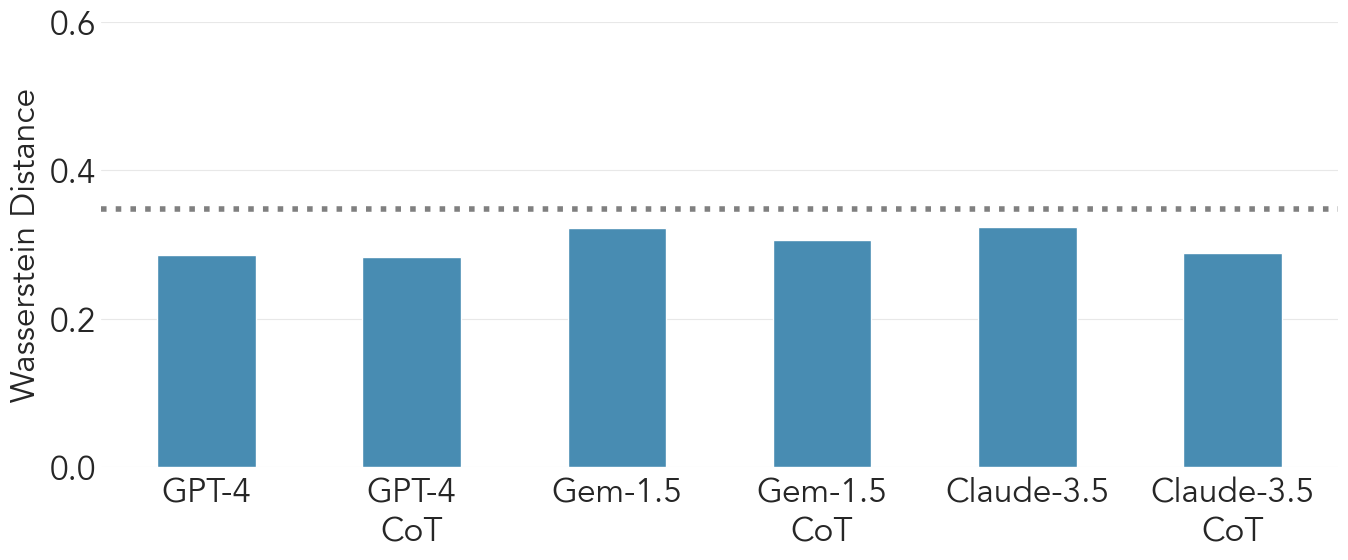

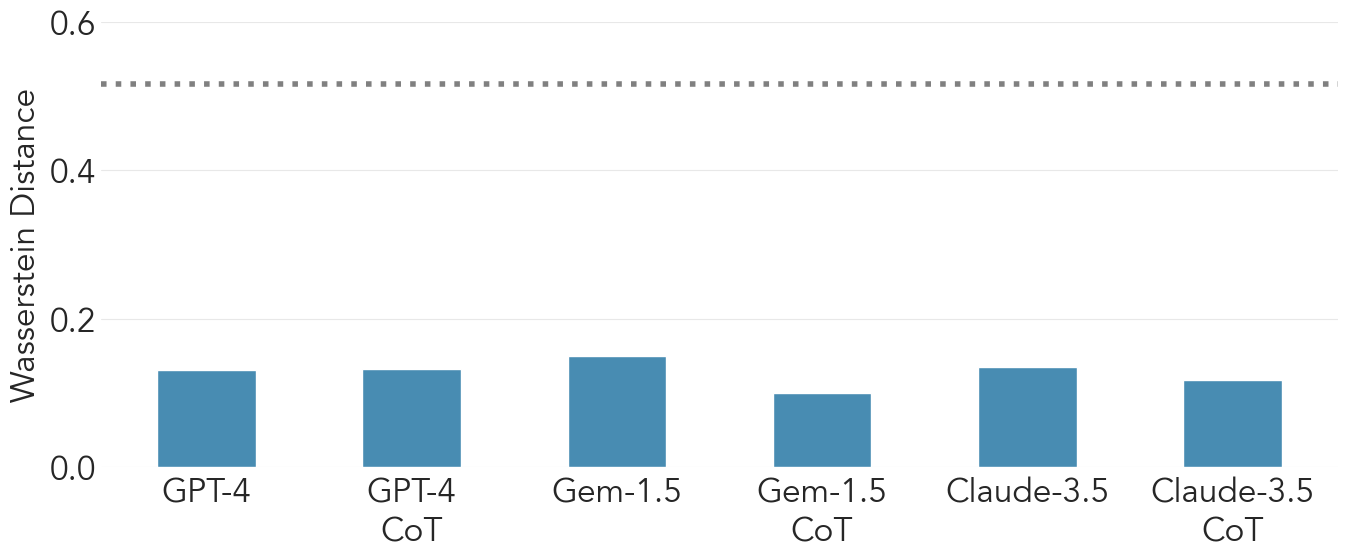

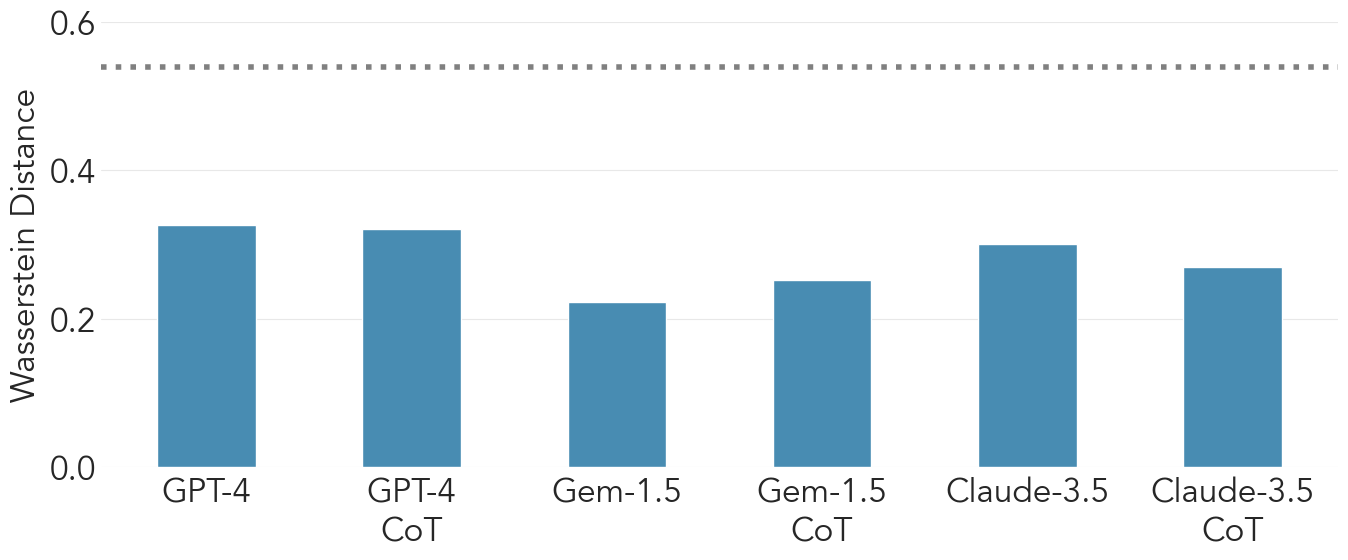

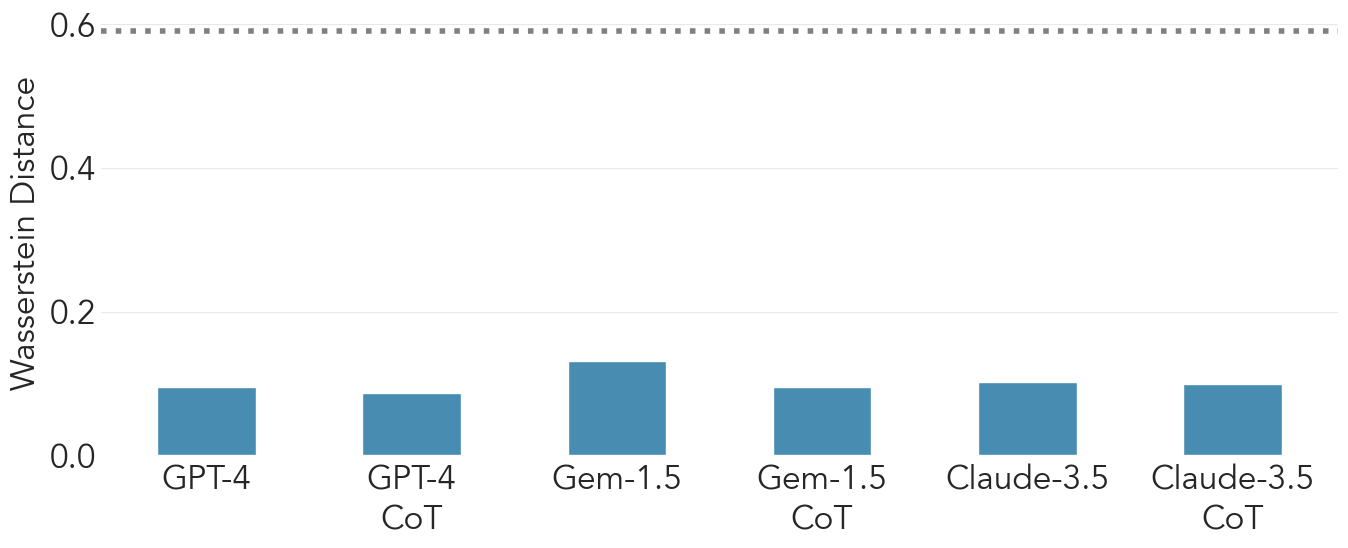

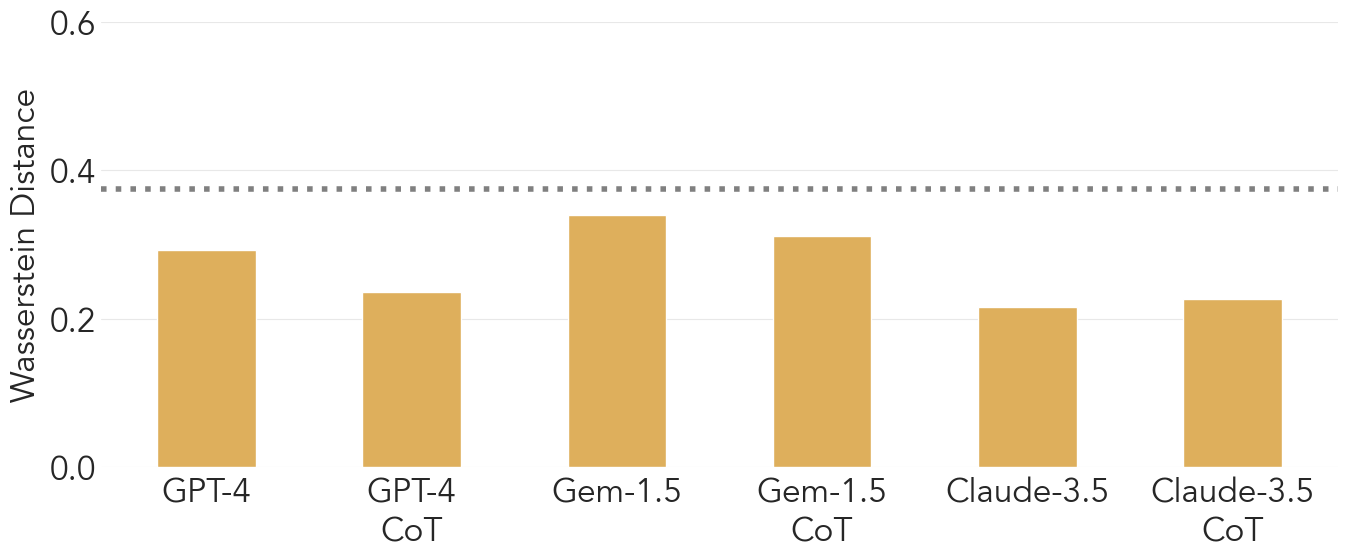

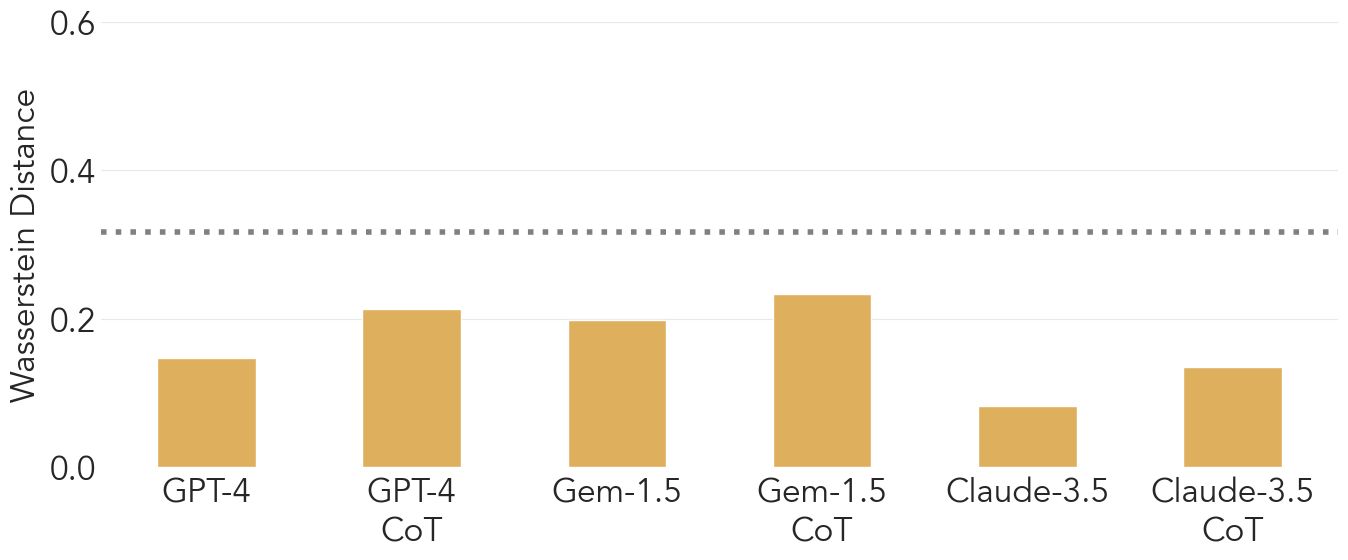

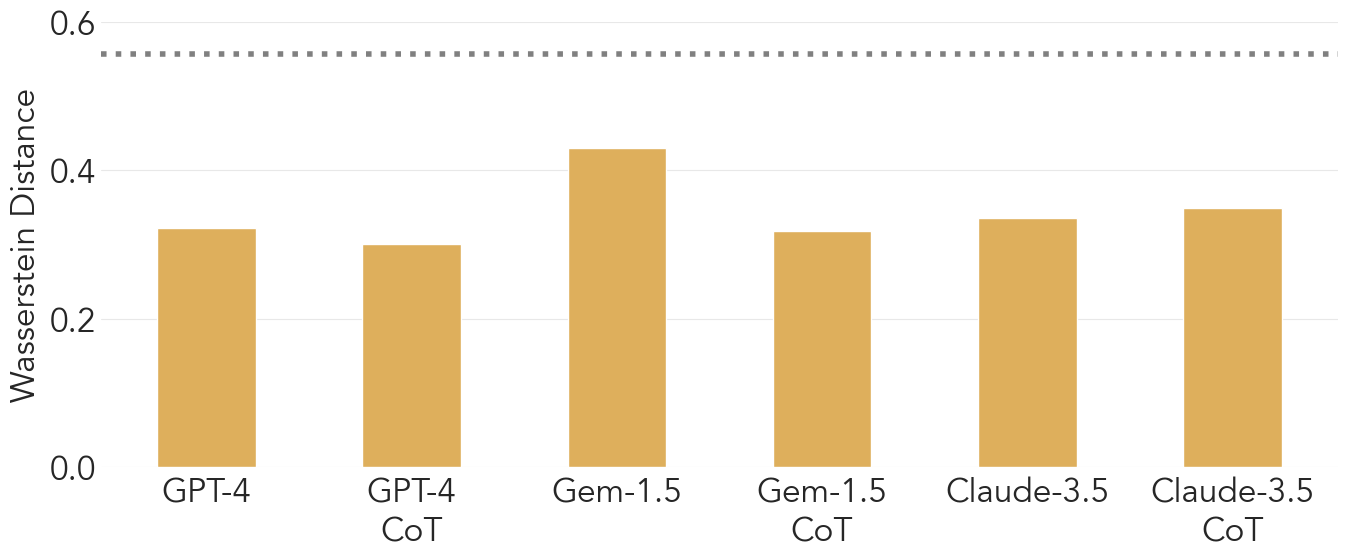

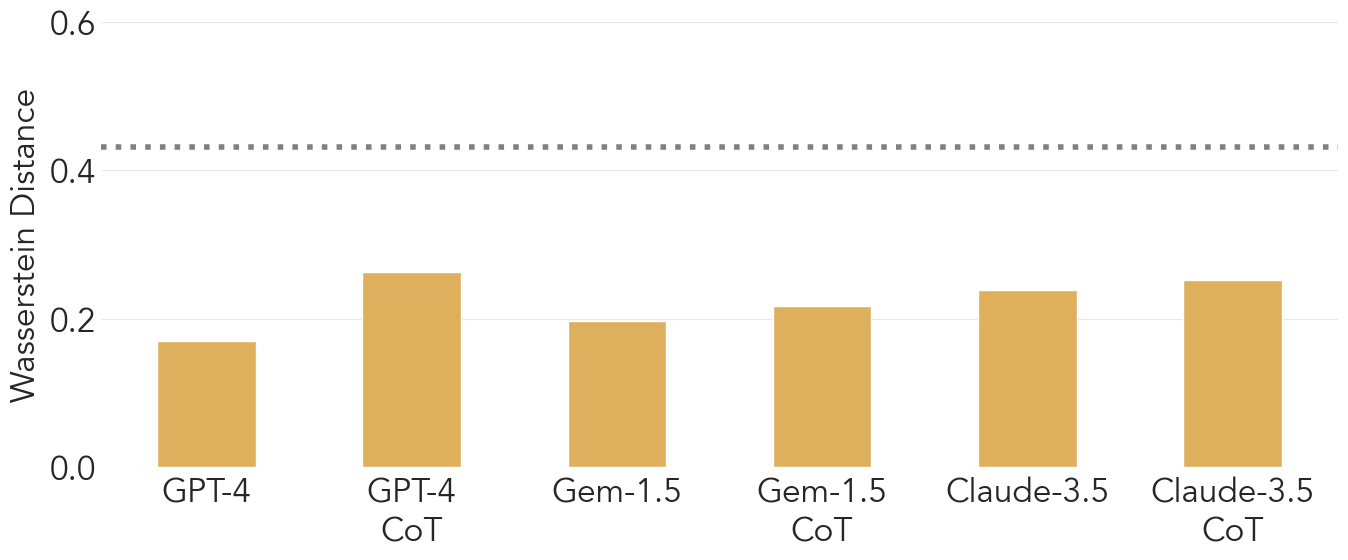

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 24

# keys are save_title, values are the keys in model_means and model_sems
plot_dict = {
    "control_jsd": ["goal_control/belief_a"],
    "goal_jsd": ["goal_control/belief_b"],
    "gc_emotion_jsd": ["goal_control/emotion"],
    "gc_outcome_jsd": ["goal_control/outcome"],
    "expected_jsd": ["safety_expected/belief_a"],
    "safety_jsd": ["safety_expected/belief_b"],
    "se_emotion_jsd": ["safety_expected/emotion"],
    "se_outcome_jsd": ["safety_expected/outcome"]
}

# make all plots
for save_title in plot_dict.keys():
    print(save_title)
    keys = plot_dict[save_title]
    categories = keys

    labels = ["GPT-4", "GPT-4\nCoT",  "Gem-1.5", "Gem-1.5\nCoT", "Claude-3.5", "Claude-3.5\nCoT"]
    model_methods = ["azure_gpt-4_0shot", "azure_gpt-4_0shot_cot", "gemini-1.5-pro-002_0shot", "gemini-1.5-pro-002_0shot_cot", "claude-3-5-sonnet-20240620_0shot", "claude-3-5-sonnet-20240620_0shot_cot"]
    # Initialize figure
    plt.figure(figsize=(14, 6))
    barWidth = 1.2
    gap = 1.3  # Increase this value to increase space between groups of bars

    num_model_methods = len(model_methods)
    num_categories = len(categories)

    # Calculate positions with increased gap
    positions = np.arange(num_model_methods) * (barWidth * num_categories + gap)

    # Adjust the positions for x-ticks to be at the center of each group of bars
    adjusted_positions = positions + (barWidth * (num_categories-1)) / 2

    # Color palette
    colorblind_palette = sns.color_palette('colorblind', n_colors=num_categories)
    if num_categories == 1:

        colorblind_palette = sns.color_palette('colorblind', n_colors=num_categories+1)
    if "col" in save_title:
        colorblind_palette = sns.color_palette('colorblind', n_colors=num_categories+4)
    print(len(colorblind_palette))
        
    colorblind_palette = [change_saturation(color, 0.6) for color in colorblind_palette]


    for i, key in enumerate(keys):
        jsds = [jsd[key][model] for model in model_methods]
        if "se" in key or "safety" in key or "expected" in key:
            color = colorblind_palette[1]
        else:
            color = colorblind_palette[0]
        plt.bar(positions + i*barWidth, jsds, width=barWidth, color=color)
    
    # draw a dotted line at chance level
    plt.axhline(y=jsd[key]["chance"], color='grey', linestyle=':', linewidth=4)

    # Adjusting the plot
    plt.ylabel('Wasserstein Distance')
    plt.xticks(adjusted_positions, labels, rotation=0)
    sns.despine(left=True, bottom=True)
    plt.grid(True, which='major', axis='y', linestyle='-', color='lightgrey', alpha=0.5)
    plt.tick_params(axis='y', length=0)
    plt.tight_layout()
    # plt.legend(loc='best', bbox_to_anchor=(0.5, -0.05), ncol=num_categories, fancybox=True, shadow=True)
    plt.yticks([0, 0.2, 0.4, 0.6])
    # Show or save plot
    # plt.show()
    plt.savefig(save_title+".png", bbox_inches='tight')  # Uncomment to save the figure
